In [1]:
# Making necessary imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import gc
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os
import timm
import pickle
import torchvision.transforms as T
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from torchlars import LARS
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfr = pd.DataFrame

In [3]:
# Fixing randomization seed for reproduceability 
def fix_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
fix_seed(42)

In [5]:
# Class ID to Labels Dictionary
labels = {
    0: "lense",
    1: "non_lense"
}

In [6]:
# Defining path variable for the dataset
data_path = "/home/shreshthsharma/ssl/real_hst"

In [7]:
# Storing file names in a list
files = sorted(os.listdir(data_path))

In [8]:
# Calculating size of dataset
len(files)

215

In [9]:
# # Checking class distribution in the dataset
num_lense = 0
num_non_lense = 0
for file in files:
    if file[:2] == "nl":
        num_non_lense += 1
    else:
        num_lense += 1

print(f"Lense Images: {num_lense}")
print(f"Non-Lense Images: {num_non_lense}")

Lense Images: 152
Non-Lense Images: 63


In [10]:
# Checking image shape
arr = np.load('/home/shreshthsharma/ssl/real_hst/nl_4_hst.npy')
arr = np.expand_dims(arr, axis=0)
arr.shape

(1, 334, 334)

In [11]:
# Initial model training results showed NaN values
# This might be possible due to NaN values of some pixels
# Analyzing how many pixels are NaN class wise
nan_lense = 0
nan_non_lense = 0
for file in files:
    arr = np.load(f'/home/shreshthsharma/ssl/real_hst/{file}')
    nan_pixels = np.sum(np.isnan(arr))
    if file[:2] == "nl":
        nan_non_lense += nan_pixels
    else:
        nan_lense += nan_pixels

print(f"Nan Pixels in Lense Images: {nan_lense}")
print(f"Nan Pixels in Non-Lense Images: {nan_non_lense}")

Nan Pixels in Lense Images: 33068
Nan Pixels in Non-Lense Images: 8804


In [12]:
# Significant number of NaN pixels
# Calculating average number of NaN pixels per image
print(f"Average Nan Pixels in Lense Images: {nan_lense/153}")
print(f"Average Nan Pixels in Non-Lense Images: {nan_non_lense/63}")

Average Nan Pixels in Lense Images: 216.13071895424838
Average Nan Pixels in Non-Lense Images: 139.74603174603175


In [13]:
# Calculating proportion of NaN pixels in a single image
print(f"Proportion of Nan Pixels in Lense Images: {(nan_lense/153)/(334*334)}")
print(f"Proportion of Nan Pixels in Non-Lense Images: {(nan_non_lense/63)/(334*334)}")

Proportion of Nan Pixels in Lense Images: 0.001937419044733124
Proportion of Nan Pixels in Non-Lense Images: 0.0012526984809963762


In [14]:
# Thus we can simply we replace NaN pixels by 0 due to very less proportion of NaN pixels

In [15]:
# Defining the data augmentations used in SimCLR 
class SimCLRTransform:
    def __init__(self, size=224):
        self.size = size

        self.color_jitter = T.ColorJitter(0.8, 0.8, 0.8, 0.2)

        self.augmentation = T.Compose([
            T.RandomResizedCrop(size=self.size),
            T.RandomHorizontalFlip(),
            T.RandomApply([self.color_jitter], p=0.8),
            T.RandomApply([T.GaussianBlur(kernel_size=self.size // 20 * 2 + 1, sigma=(0.1, 2.0))], p=0.5)
        ])

    def __call__(self, x):
        # Apply data augmentation transformations
        x1 = self.augmentation(x)
        x2 = self.augmentation(x)

        return {'X1': x1, 'X2': x2}

In [16]:
transform = SimCLRTransform(size=224)

In [17]:
# Defining the Dataset Class
class Data(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.files = sorted(os.listdir(self.path))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file_path = self.path+"/"+self.files[index]
        arr = np.load(file_path)
        arr[np.isnan(arr)] = 0 # Replacing NaN values by 0
        arr = torch.tensor(np.float32(arr)).unsqueeze(dim=0)
        image_pair = transform(arr)
        if self.files[index][:2] == "nl":
            lbl = torch.tensor(1)
        else:
            lbl = torch.tensor(0)
        
        return {'X_orig': arr, 'X1': image_pair['X1'], 'X2': image_pair['X2'], 'y': lbl}

In [18]:
# Creating dataset object
dataset = Data(path=data_path)

In [19]:
# Confirming length of dataset
len(dataset)

215

In [20]:
# Sanity Check
dataset[0]

{'X_orig': tensor([[[0.0857, 0.0932, 0.0847,  ..., 0.0720, 0.0760, 0.0779],
          [0.0777, 0.0838, 0.0888,  ..., 0.0814, 0.0833, 0.0815],
          [0.0870, 0.0842, 0.0821,  ..., 0.0724, 0.0823, 0.0800],
          ...,
          [0.0820, 0.0859, 0.0837,  ..., 0.0826, 0.0789, 0.0865],
          [0.0770, 0.0851, 0.0841,  ..., 0.0901, 0.0843, 0.0793],
          [0.0810, 0.0730, 0.0814,  ..., 0.0728, 0.0872, 0.0880]]]),
 'X1': tensor([[[0.0533, 0.0683, 0.0731,  ..., 0.1790, 0.1646, 0.1773],
          [0.0677, 0.0684, 0.0632,  ..., 0.1822, 0.1765, 0.1630],
          [0.0589, 0.0542, 0.0677,  ..., 0.1774, 0.1501, 0.1488],
          ...,
          [0.0613, 0.0598, 0.0619,  ..., 0.0566, 0.0635, 0.0595],
          [0.0561, 0.0575, 0.0757,  ..., 0.0616, 0.0739, 0.0573],
          [0.0650, 0.0498, 0.0631,  ..., 0.0476, 0.0666, 0.0565]]]),
 'X2': tensor([[[0.0802, 0.0802, 0.0799,  ..., 0.0808, 0.0803, 0.0801],
          [0.0801, 0.0801, 0.0798,  ..., 0.0807, 0.0802, 0.0800],
          [0.0798,

In [21]:
# Creating the list of target labels
labels = []
lis = sorted(os.listdir(data_path))
for file in lis:
    if file[:2] == "nl":
        labels.append(1)
    else:
        labels.append(0)

In [22]:
# Selecting indexes for a stratified dataset split: 90% Training and 10% Validation
train_idxs, valid_idxs = train_test_split(np.arange(len(labels)), train_size = 0.9, stratify=labels, random_state = 42)

In [23]:
# Creating training and validation dataset objects by taking subsets of the data based on indexes
train_dataset = Subset(dataset, train_idxs)
valid_dataset = Subset(dataset, valid_idxs)

In [24]:
# Checking the device for training and inference
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
# Clear CUDA cache
torch.cuda.empty_cache()

# Perform garbage collection
gc.collect()

319

In [26]:
# Defining the SimCLR Model Class: Backbone + Embedding Projection Head
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512,512,128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [35]:
# Importing the model from timm and creating the SimCLR Model object
model = timm.create_model('resnet18.tv_in1k', in_chans=1, pretrained=True)
backbone = nn.Sequential(*list(model.children())[:-1])
model = SimCLR(backbone)

In [36]:
# Sanity check
model(torch.randn(16,1,224,224)).shape

torch.Size([16, 128])

In [37]:
# SimCLR benefits from large batch size to generate better embeddings. Change the variable below in case of a larger variable
training_batch_size = 128

In [38]:
# Definining dataloaders
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [39]:
# Note: Even though original SimCLR pipeline uses Cosine Annealing as the scheduler, in my experimentation ReduceLROnPlateau reported better results on the validation dataset
# Hence, I have used ReduceLROnPlateau.

In [40]:
# Note: Even though original SimCLR pipeline uses Cosine Annealing as the scheduler, in my experimentation ReduceLROnPlateau reported better results on the validation dataset
# Hence, I have used ReduceLROnPlateau

In [41]:
# Training configuration
model.to(device)
epochs = 15
loss_fn = NTXentLoss()
base_optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
optimizer = LARS(optimizer=base_optimizer, eps=1e-8, trust_coef=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.01, min_lr=1e-6)
best_epoch = 0
best_loss = 1e+9
stop_thresh = 4
loss_lis = []

In [42]:
# Training Loop
# Skip this cell if you want to perform inference only
for epoch in tqdm(range(epochs)):
    ntxent_loss = 0
    model.train()
    for batch in train_loader:
        for k,v in batch.items():
            batch[k] = v.to(device)
        optimizer.zero_grad()
        z1 = model(batch['X1'])
        z2 = model(batch['X2'])
        loss = loss_fn(z1, z2)
        loss.backward()
        optimizer.step()
        ntxent_loss += loss.item()
    ntxent_loss /= len(train_loader)
    print(ntxent_loss)
    loss_lis.append(ntxent_loss)
    scheduler.step(ntxent_loss)

    if ntxent_loss < best_loss:
        best_epoch = epoch
        best_loss = ntxent_loss
        print(f"Save model at {best_epoch}")
        torch.save(model.state_dict(),"task2_models/best_encoder.pth")
    
    # Early Stopping
    if epoch - best_epoch > stop_thresh:
        print("Early Stopping!")
        break

  0%|          | 0/15 [00:00<?, ?it/s]

5.115152835845947
Save model at 0
4.996930122375488
Save model at 1
4.9510979652404785
Save model at 2
5.020533323287964
4.9835591316223145
4.811880588531494
Save model at 5
4.828495264053345
4.926481246948242
4.825707674026489
4.824260950088501
4.847047805786133
Early Stopping!


In [54]:
# Loading the best model and creating the 128 dimensional embeddings for both the training and validation dataset
model.load_state_dict(torch.load("task2_models/best_encoder.pth"))
model.to(device)
train_enc = []
train_labels = []
valid_enc = []
valid_labels = []
model.eval()
for batch in train_loader:
    for k,v in batch.items():
        batch[k] = v.to(device)
    with torch.no_grad():
        encs = model(batch['X_orig'])
        labels = batch['y']
    encs = encs.cpu().tolist()
    labels = labels.cpu().tolist()
    for enc in encs:
        train_enc.append(enc)
    for label in labels:
        train_labels.append(label)

for batch in valid_loader:
    for k,v in batch.items():
        batch[k] = v.to(device)
    with torch.no_grad():
        encs = model(batch['X_orig'])
        labels = batch['y']
    encs = encs.cpu().tolist()
    labels = labels.cpu().tolist()
    for enc in encs:
        valid_enc.append(enc)
    for label in labels:
        valid_labels.append(label)


# Creating numpy arrays for the embeddings and labels of both the training and validation dataset
train_enc = np.array(train_enc)
train_labels = np.array(train_labels)
valid_enc = np.array(valid_enc)
valid_labels = np.array(valid_labels)

In [55]:
# Skip this cell if you want to perform inference only
# Creating a Logisitic Regression model for classification based on the created SimCLR embeddings
# The classifier is trained only on the training dataset
classifier = LogisticRegression()
classifier.fit(X=train_enc, y=train_labels)

# Saving the logistic regression model
with open('task2_models/classifier_logreg.pkl', 'wb') as f:
    pickle.dump(classifier, f)

LogisticRegression()

In [57]:
# Loading the logistic regression model
with open('task2_models/classifier_logreg.pkl', 'rb') as f:
    classifier = pickle.load(f)

In [58]:
# Calculatiing predictions on both the training and validation dataset
preds_train = classifier.predict(X=train_enc)
preds_valid = classifier.predict(X=valid_enc)

In [59]:
# Calculating ROC-AUC Score on both the training and validation dataset
metric_train = roc_auc_score(y_true=train_labels, y_score=preds_train)
metric_valid = roc_auc_score(y_true=valid_labels, y_score=preds_valid)
print("Training Dataset ROC-AUC Score:", metric_train)
print("Validation Dataset ROC-AUC Score:", metric_valid)

Training Dataset ROC-AUC Score: 0.720717234262126
Validation Dataset ROC-AUC Score: 0.6041666666666666


In [60]:
# Storing FPR, TPR, and ROC-AUC for each class for plotting ROC Curve for both the training and validation datasets
fpr_train, tpr_train, _ = roc_curve(y_true=train_labels, y_score=preds_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_valid, tpr_valid, _ = roc_curve(y_true=valid_labels, y_score=preds_valid)
roc_auc_valid = auc(fpr_valid, tpr_valid)

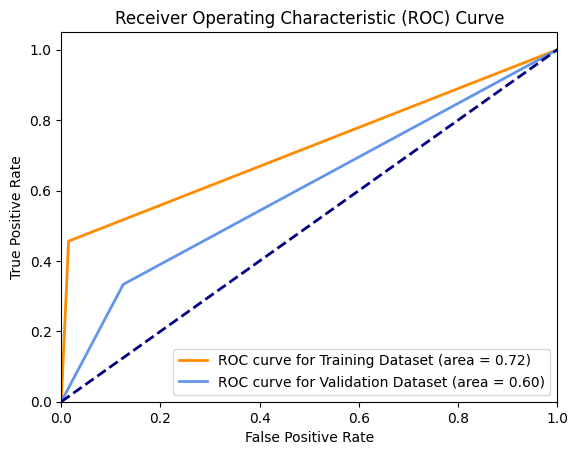

In [61]:
# Plotting ROC curves for both the training and validation datasets
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='ROC curve for Training Dataset (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_valid, tpr_valid, color='cornflowerblue', lw=lw, label='ROC curve for Validation Dataset (area = %0.2f)' % roc_auc_valid)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()